<a href="https://colab.research.google.com/github/tiwarylab/DynamicsAE/blob/main/DynAE_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DynAE Demo 2023
This notebook aims to serve as a simple introduction to the dynamics constrained auto-encoder (Dynamics-AE) method ([https://arxiv.org/abs/2209.00905](https://arxiv.org/abs/2209.00905)). The code is implemented using Pytorch.

## Clone the Github to Colab

In [1]:
!git clone https://github.com/tiwarylab/DynamicsAE

Cloning into 'DynamicsAE'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 70 (delta 29), reused 58 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 24.74 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
%cd DynamicsAE
%pwd

/content/DynamicsAE


'/content/DynamicsAE'

In [3]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = [25, 20]
np.random.seed(42)

In [4]:
large = 54; med = 36; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'legend.title_fontsize':large,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

## Data Preparation
The trajectory data can be generated from the molecular dynamics simulation or experiements. Here, we use a sample trajectory generated from Langevin dynamics simulation of a three-well analytical potential.

In [5]:
# Load trajectory data
traj_data = np.load("examples/three_state_traj_data200k.npy")

### Visualization of the trajectory

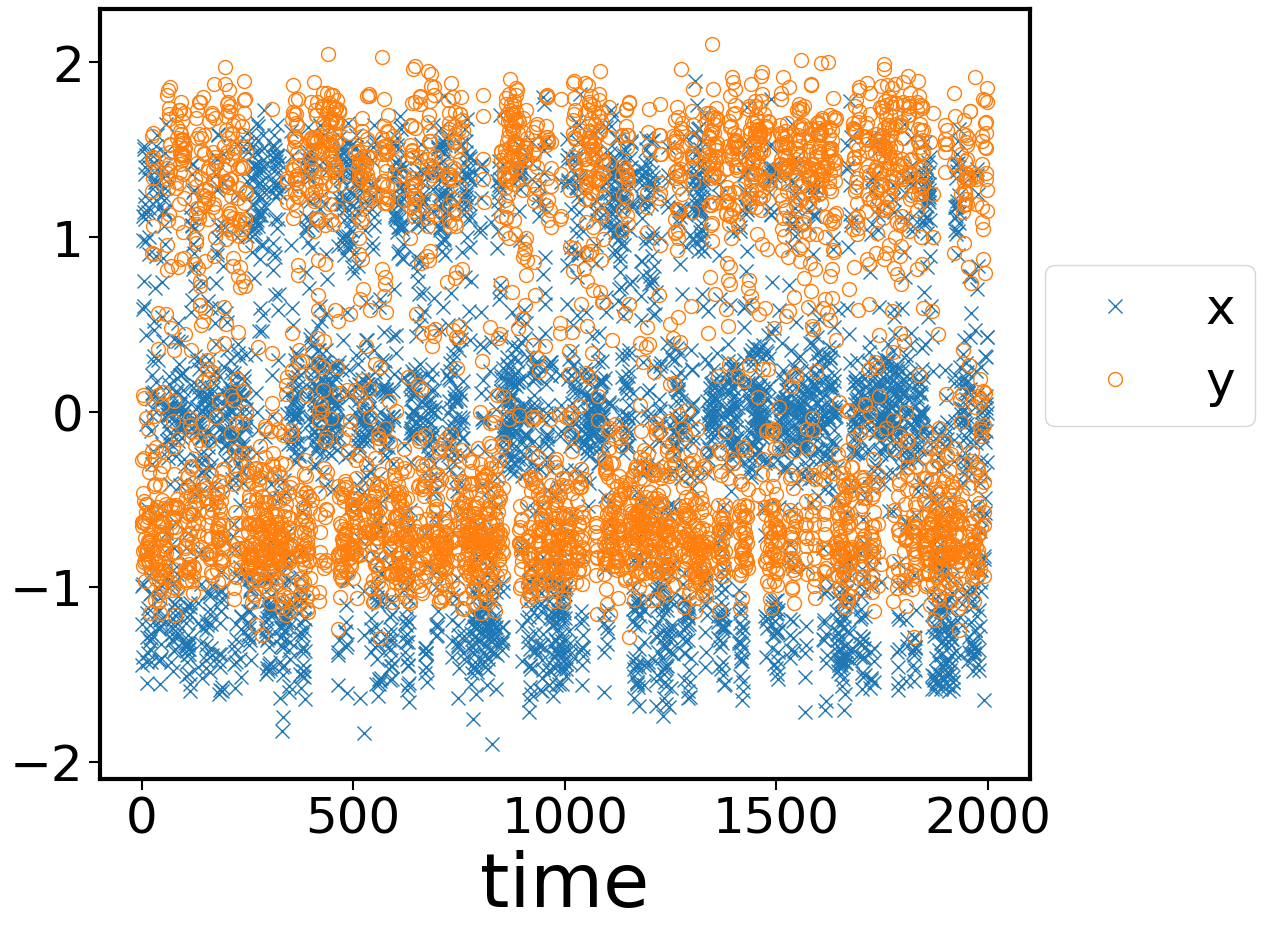

In [6]:
fig, ax = plt.subplots(figsize=(12,10))

t = np.arange(traj_data.shape[0])*0.01
ax.plot(t[::50],traj_data[::50,0],'x',label='x')
ax.plot(t[::50],traj_data[::50,1],'o',fillstyle='none',label='y')
ax.set_xlabel('time')
ax.legend(fontsize=36,bbox_to_anchor=(0.99, 0.7))

Text(0, 0.5, 'y')

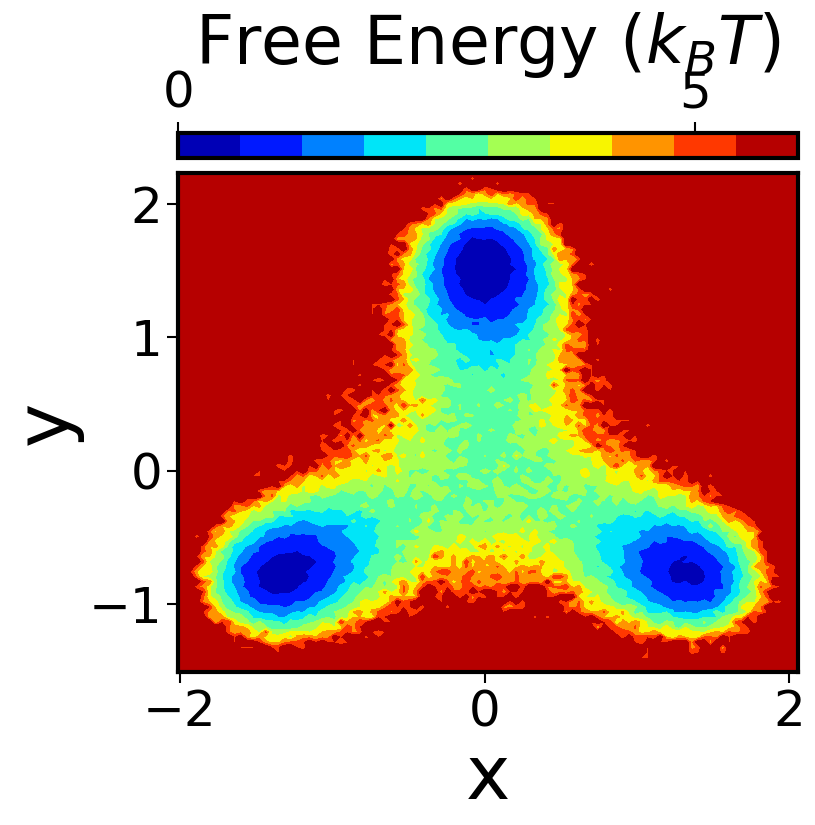

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(traj_data[:,0],traj_data[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")

### Warping the data with a nonlinear mapping function

In [8]:
# coordinate transformation
traj_data_transformed = traj_data[:,:2].copy()

traj_data_transformed[:,1] = traj_data_transformed[:,1] + traj_data_transformed[:,0]**2

np.save('examples/three_state_transformed_traj_data200k.npy',traj_data_transformed)

Text(0, 0.5, "y'")

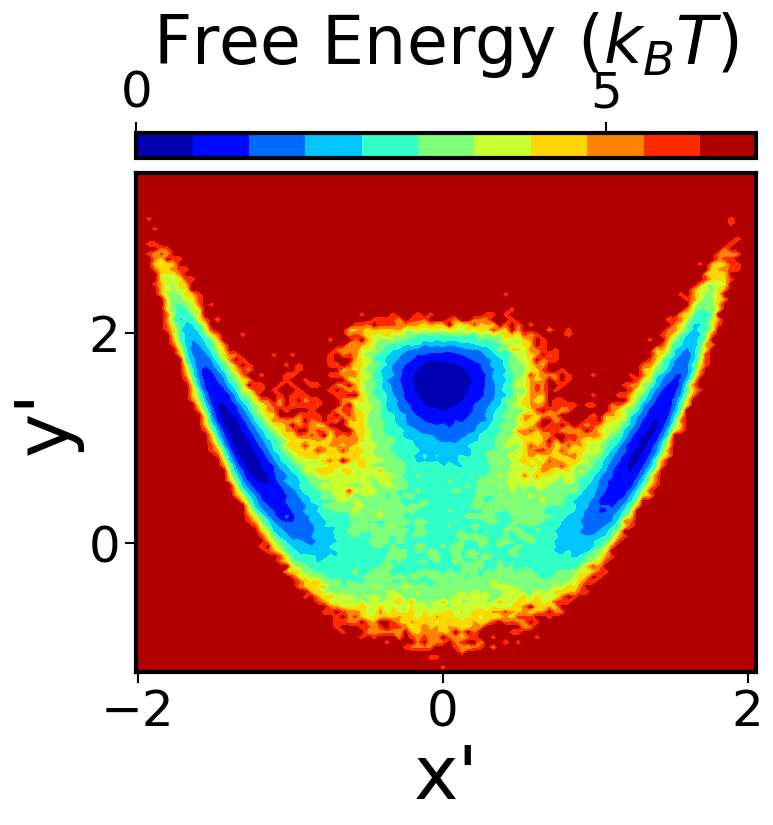

In [9]:
# visualize the transformed trajectory data
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(traj_data_transformed[:,0],traj_data_transformed[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"x'")
ax.set_ylabel(r"y'")

In [11]:
def plot_ellipse(diff, x, ax, plot_scale=1, color='k'):
    """Plots the ellipse corresponding to a given covariance matrix at x (2D)
    Args:
        cov (array): 2 by 2 symmetric positive definite array.
        x (vector): 2 by 1 vector.
        scale (float, optional): Scale for ellipse size. Defaults to 1.
    """
    t = np.linspace(0, 2*np.pi)
    a = np.vstack([plot_scale*diff[0]*np.cos(t), plot_scale*diff[1]*np.sin(t)])
    ax.plot(a[0, :] + x[0], a[1, :] + x[1], linewidth=1, c=color)

In [12]:
# import the required packages
import numpy as np
import torch
import os
import sys
import random
import torch.nn.functional as F

from models.VAE import VAE
from models.DynamicsAE import DynamicsAE
import utils

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
default_device = torch.device("cpu")
print(device, default_device)

cpu cpu


## 1. transformed 3-well potential (2-2-2)

In [14]:
# Settings
# ------------------------------------------------------------------------------
# By default, we save all the results in subdirectories of the following path.
base_path = "3w_222_Results"

# Model parameters

# By default, we use all the all the data to train and test our model
t0 = 0
# By default, set dt = 0 like normal auto-encoder
dt = 0

# Dimension of RC or bottleneck
z_dim = 2

# Encoder type (fc_encoder or conv_encoder)
encoder_type = 'fc_encoder'

# Decoder type (fc_decoder or deconv_decoder)
decoder_type = 'fc_decoder'

# Number of nodes in each hidden layer of the encoder
neuron_num1 = 32
# Number of nodes in each hidden layer of the encoder
neuron_num2 = 32

# Model (VAE or DynamicsAE)
model_type = 'DynamicsAE'
model_path = os.path.join(base_path, "DynAE")

# if model_type == 'DynamicsAE':
# Number of projections to approximate sliced wasserstein distance
projection_num = 50

# Minimal distances between cluster centers
min_dist = 5

# Bias factor for resampling
bias_factor = 2

# Prior dynamics (only support Langevin for now)
prior_dynamics = 'Langevin'

# Training parameters
batch_size = 256

# Number of epochs with the change of the state population smaller than the threshold after which this iteration of training finishes
max_epochs = 50

# By default, we save the model every 1 epoch
log_interval = 10

# Period of learning rate decay
lr_scheduler_step_size = 100

# Multiplicative factor of learning rate decay. Default: 1 (No learning rate decay)
lr_scheduler_gamma = 1

# learning rate of Adam optimizer for IB
learning_rate = 1e-3

# Hyper-parameter beta
beta = 10

# Import data

# Load the data
# Path to the input trajectory data
input_data_list = [np.load('examples/three_state_transformed_traj_data200k.npy')]

input_data_list = [torch.from_numpy(input_data).float().to(default_device)\
                  for input_data in input_data_list]

# Path to the target data
target_data_list = [torch.from_numpy(np.load('examples/three_state_transformed_traj_data200k.npy')).float().to(default_device)]

assert len(input_data_list)==len(target_data_list)

# Other controls

# Random seed
seed = 1

# Whether to save trajectory results
SaveTrajResults = True

# Whether to save training progress
SaveTrainingProgress = False

In [15]:
# Train and Test our model
# ------------------------------------------------------------------------------

final_result_path = model_path + '_result.dat'
os.makedirs(os.path.dirname(final_result_path), exist_ok=True)
if os.path.exists(final_result_path):
    print("Final Result", file=open(final_result_path, 'a'))  # append if already exists
else:
    print("Final Result", file=open(final_result_path, 'w'))

# set the random seed
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

data_init_list = []
for i in range(len(input_data_list)):
    data_init_list += [utils.data_init(t0, dt, input_data_list[i], target_data_list[i])]

data_shape = data_init_list[0][0]

train_past_data0 = torch.cat([data_init_list[i][1] for i in range(len(input_data_list))], dim=0)
train_past_data1 = torch.cat([data_init_list[i][2] for i in range(len(input_data_list))], dim=0)
train_target_data0 = torch.cat([data_init_list[i][3] for i in range(len(input_data_list))], dim=0)
train_target_data1 = torch.cat([data_init_list[i][4] for i in range(len(input_data_list))], dim=0)

test_past_data0 = torch.cat([data_init_list[i][5] for i in range(len(input_data_list))], dim=0)
test_past_data1 = torch.cat([data_init_list[i][6] for i in range(len(input_data_list))], dim=0)
test_target_data0 = torch.cat([data_init_list[i][7] for i in range(len(input_data_list))], dim=0)
test_target_data1 = torch.cat([data_init_list[i][8] for i in range(len(input_data_list))], dim=0)

output_shape = train_target_data0.shape[1:]

# if model_type == 'DynamicsAE':
prior_learning_rate = learning_rate
output_path = model_path + "_d=%d_dmin=%.1f_b=%f_lr=%f" \
              % (z_dim, min_dist, beta, learning_rate)

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

AE_model.to(device)

AE_model.train()

train_result = AE_model.train_model(beta, input_data_list, train_past_data0,
                                  train_past_data1, train_target_data0,
                                  train_target_data1,
                                  test_past_data0, test_past_data1, test_target_data0,
                                  test_target_data1,
                                  learning_rate, prior_learning_rate,
                                  lr_scheduler_step_size, lr_scheduler_gamma,
                                  batch_size, max_epochs,
                                  output_path, log_interval,
                                  SaveTrainingProgress, seed)

AE_model.eval()
AE_model.output_final_result(train_past_data0, train_past_data1, train_target_data0, train_target_data1,
                          test_past_data0, test_past_data1, test_target_data0, test_target_data1,
                          batch_size, output_path, final_result_path, beta,
                          learning_rate, seed)

for i in range(len(input_data_list)):
    AE_model.save_traj_results(input_data_list[i], batch_size, output_path, SaveTrajResults, i, seed)

Iteration 500:	Time 5.950493 s
Loss (train) 1.194085	Regularization loss (train): 2.971625
Reconstruction loss (train) 0.896923	 Prior loss (train) -2.531954
Loss (test) 31.445568	Regularization loss (test): 3.047815
Reconstruction loss (test) 0.967416	 Prior loss (test) -2.658487
Epoch: 1

Finished after 0.3081629276275635s
3 cluster centers detected

Iteration 1000:	Time 11.384800 s
Loss (train) 3.840345	Regularization loss (train): 0.381902
Reconstruction loss (train) 0.021324	 Prior loss (train) 0.527323
Loss (test) 1.177237	Regularization loss (test): 0.115974
Reconstruction loss (test) 0.017492	 Prior loss (test) 0.801424
Epoch: 2

Finished after 0.3946056365966797s
14 cluster centers detected

Iteration 1500:	Time 17.799666 s
Loss (train) 2.531568	Regularization loss (train): 0.247675
Reconstruction loss (train) 0.054814	 Prior loss (train) 0.870122
Loss (test) 2.009983	Regularization loss (test): 0.196918
Reconstruction loss (test) 0.040801	 Prior loss (test) 0.721715
Epoch: 3


In [16]:
prefix=f'{base_path}/DynAE_d=2_dmin=5.0_b=10.000000_lr=0.001000'
repeat='1'

In [17]:
# load the results
# the latent representation recovered by Dynamics-AE
latent_rep=np.load(prefix+"_traj0_representation"+repeat+".npy")
# the reconstruction leanred by Dynamics-AE
reconstruction=np.load(prefix+"_traj0_data_prediction"+repeat+".npy")
# the cluster centers from regular space clustering in the latent space
cluster_centers=np.load(prefix+'_z_cluster_centers'+repeat+".npy")

(np.float64(-17.03491973876953),
 np.float64(23.294214248657227),
 np.float64(-21.836700439453125),
 np.float64(16.693021774291992))

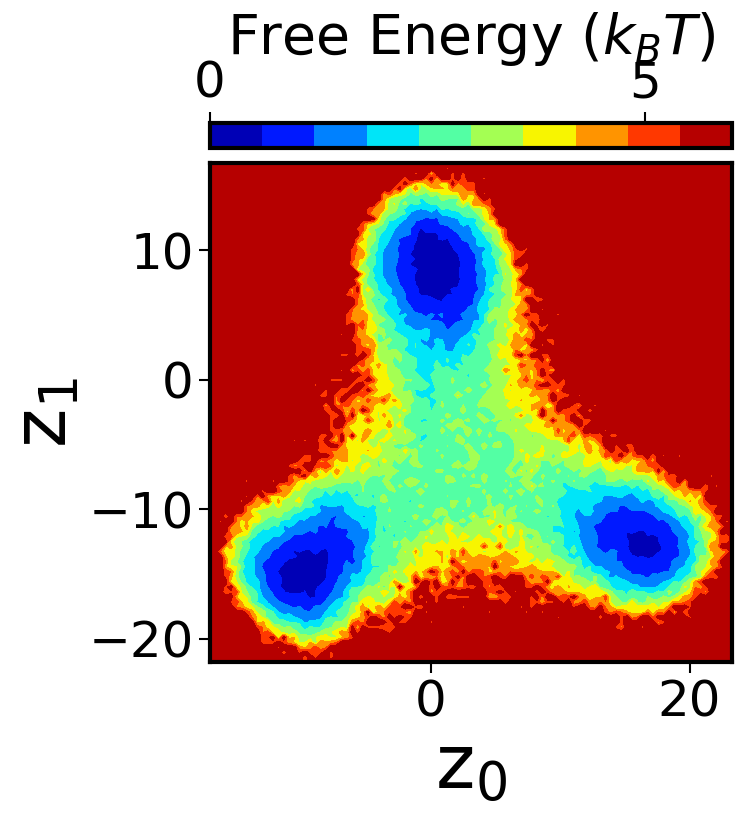

In [18]:
# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.axis('equal')

Text(0, 0.5, "$\\hat{y}$'")

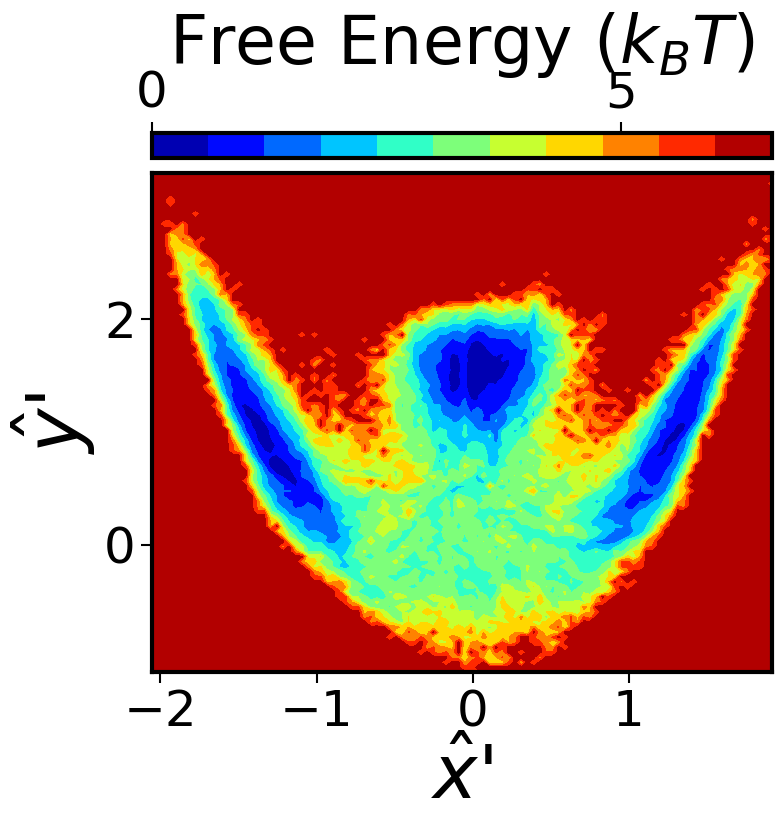

In [19]:
# visualize the reconstruction
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(reconstruction[:,0],reconstruction[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"$\hat{x}$'")
ax.set_ylabel(r"$\hat{y}$'")

In [20]:
# load the finally saved DynamicsAE model
import torch
from models.DynamicsAE import DynamicsAE

z_dim=2
output_shape=(2,)
data_shape=(2,)

neuron_num1=32
neuron_num2=32

projection_num=50
min_dist = 5
bias_factor = 2

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

restore_path=prefix+'cpt1/DynAE_final_cpt.pt'

encoder_type = 'fc_encoder'

decoder_type = 'fc_decoder'

prior_dynamics = 'Langevin'

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

checkpoint=torch.load(restore_path)

AE_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


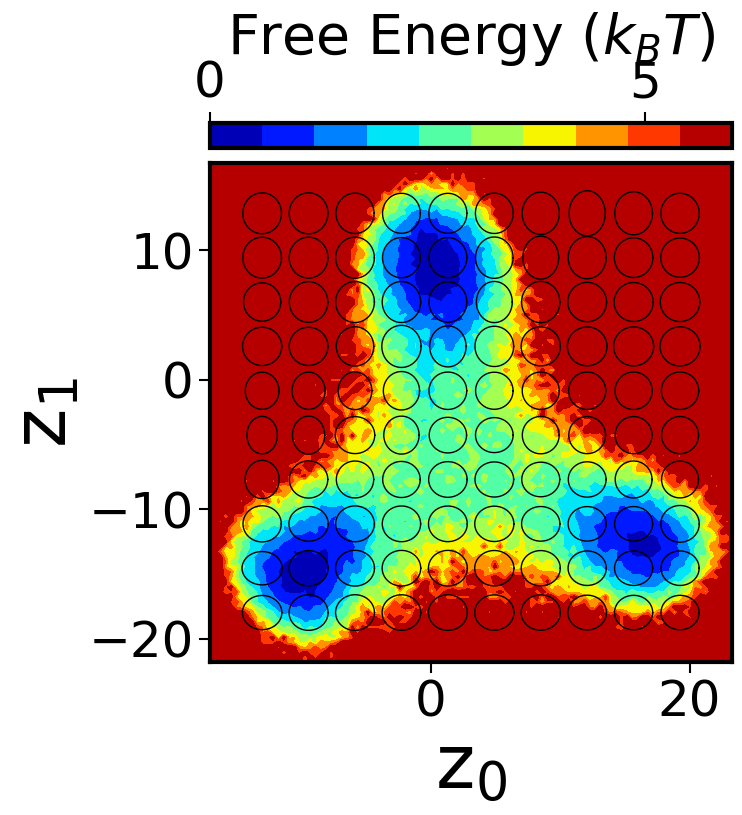

In [21]:
# plot the diffusion learned DynamicsAE
n_pts = 10
batch_size = 256
margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
xx = xx.flatten().cpu().detach().numpy()
yy = yy.flatten().cpu().detach().numpy()
diff = AE_model.model_prior.prior_logdiff(zz).exp()

diff = diff.cpu().detach().numpy()
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.axis('equal')

for i in range(len(xx)):
    plot_ellipse(diff[i], zz[i], ax, plot_scale=1.5)

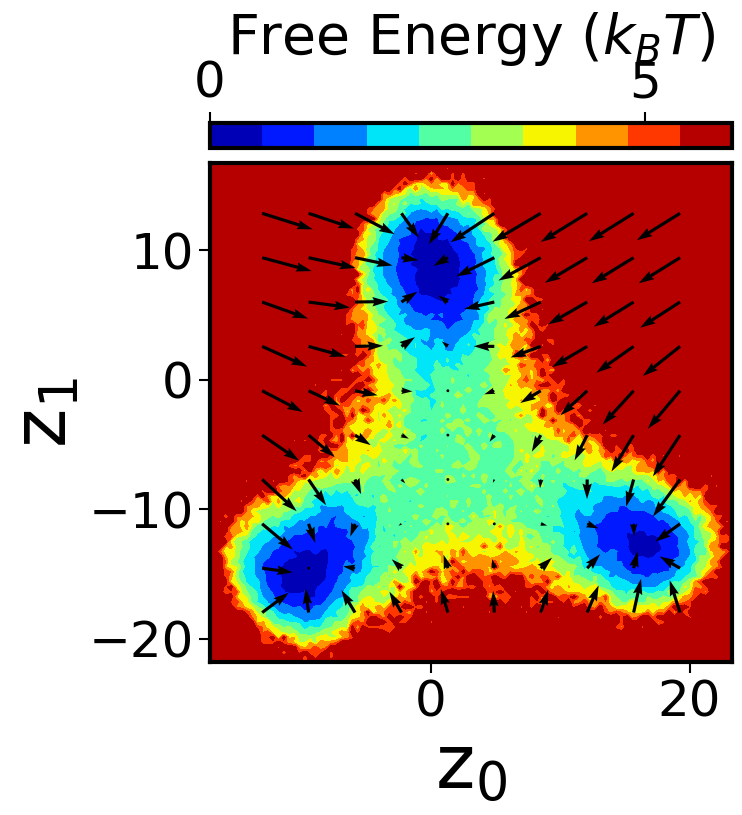

In [22]:
# plot the force field learned DynamicsAE
n_pts = 10
batch_size = 256

margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
zz.requires_grad = True

force = AE_model.model_prior.prior_force(zz)

force = force.cpu().detach().numpy()
force[:,0]=force[:,0]
force[:,1]=force[:,1]
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.set_xlim()
ax.axis('equal')

#ax.quiver(xx,yy,force[:,0],force[:,1]/yy.std)
ax.quiver(xx,yy,force[:,0],force[:,1])

## 2. transformed 3-well potential w. 1D noise (3-2-3)

In [26]:
# Settings
# ------------------------------------------------------------------------------
# By default, we save all the results in subdirectories of the following path.
base_path = "3w_323_Results"

# Model parameters

# By default, we use all the all the data to train and test our model
t0 = 0
# By default, set dt = 0 like normal auto-encoder
dt = 0

# Dimension of RC or bottleneck
z_dim = 2

# Encoder type (fc_encoder or conv_encoder)
encoder_type = 'fc_encoder'

# Decoder type (fc_decoder or deconv_decoder)
decoder_type = 'fc_decoder'

# Number of nodes in each hidden layer of the encoder
neuron_num1 = 32
# Number of nodes in each hidden layer of the encoder
neuron_num2 = 32

# Model (VAE or DynamicsAE)
model_type = 'DynamicsAE'
model_path = os.path.join(base_path, "DynAE")

# if model_type == 'DynamicsAE':
# Number of projections to approximate sliced wasserstein distance
projection_num = 50

# Minimal distances between cluster centers
min_dist = 5

# Bias factor for resampling
bias_factor = 2

# Prior dynamics (only support Langevin for now)
prior_dynamics = 'Langevin'

# Training parameters
batch_size = 256

# Number of epochs with the change of the state population smaller than the threshold after which this iteration of training finishes
max_epochs = 50

# By default, we save the model every 1 epoch
log_interval = 10

# Period of learning rate decay
lr_scheduler_step_size = 100

# Multiplicative factor of learning rate decay. Default: 1 (No learning rate decay)
lr_scheduler_gamma = 1

# learning rate of Adam optimizer for IB
learning_rate = 1e-3

# Hyper-parameter beta
beta = 10

# Import data

# Load the data
# Path to the input trajectory data
traj = np.load('examples/three_state_transformed_traj_data200k.npy')
traj = np.concatenate((traj, np.random.randn(len(traj), 1)), axis=1)
input_data_list = [traj]

input_data_list = [torch.from_numpy(input_data).float().to(default_device)\
                  for input_data in input_data_list]

# Path to the target data
target_data_list = [torch.from_numpy(traj).float().to(default_device)]

assert len(input_data_list)==len(target_data_list)

# Other controls

# Random seed
seed = 1

# Whether to save trajectory results
SaveTrajResults = True

# Whether to save training progress
SaveTrainingProgress = False

In [27]:
# Train and Test our model
# ------------------------------------------------------------------------------

final_result_path = model_path + '_result.dat'
os.makedirs(os.path.dirname(final_result_path), exist_ok=True)
if os.path.exists(final_result_path):
    print("Final Result", file=open(final_result_path, 'a'))  # append if already exists
else:
    print("Final Result", file=open(final_result_path, 'w'))

np.save(f"{base_path}/inputX.npy", traj)

# set the random seed
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

data_init_list = []
for i in range(len(input_data_list)):
    data_init_list += [utils.data_init(t0, dt, input_data_list[i], target_data_list[i])]

data_shape = data_init_list[0][0]

train_past_data0 = torch.cat([data_init_list[i][1] for i in range(len(input_data_list))], dim=0)
train_past_data1 = torch.cat([data_init_list[i][2] for i in range(len(input_data_list))], dim=0)
train_target_data0 = torch.cat([data_init_list[i][3] for i in range(len(input_data_list))], dim=0)
train_target_data1 = torch.cat([data_init_list[i][4] for i in range(len(input_data_list))], dim=0)

test_past_data0 = torch.cat([data_init_list[i][5] for i in range(len(input_data_list))], dim=0)
test_past_data1 = torch.cat([data_init_list[i][6] for i in range(len(input_data_list))], dim=0)
test_target_data0 = torch.cat([data_init_list[i][7] for i in range(len(input_data_list))], dim=0)
test_target_data1 = torch.cat([data_init_list[i][8] for i in range(len(input_data_list))], dim=0)

output_shape = train_target_data0.shape[1:]

# if model_type == 'DynamicsAE':
prior_learning_rate = learning_rate
output_path = model_path + "_d=%d_dmin=%.1f_b=%f_lr=%f" \
              % (z_dim, min_dist, beta, learning_rate)

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

AE_model.to(device)

AE_model.train()

train_result = AE_model.train_model(beta, input_data_list, train_past_data0,
                                  train_past_data1, train_target_data0,
                                  train_target_data1,
                                  test_past_data0, test_past_data1, test_target_data0,
                                  test_target_data1,
                                  learning_rate, prior_learning_rate,
                                  lr_scheduler_step_size, lr_scheduler_gamma,
                                  batch_size, max_epochs,
                                  output_path, log_interval,
                                  SaveTrainingProgress, seed)

AE_model.eval()
AE_model.output_final_result(train_past_data0, train_past_data1, train_target_data0, train_target_data1,
                          test_past_data0, test_past_data1, test_target_data0, test_target_data1,
                          batch_size, output_path, final_result_path, beta,
                          learning_rate, seed)

for i in range(len(input_data_list)):
    AE_model.save_traj_results(input_data_list[i], batch_size, output_path, SaveTrajResults, i, seed)

Iteration 500:	Time 5.144139 s
Loss (train) 2.389639	Regularization loss (train): 1.523912
Reconstruction loss (train) 2.237248	 Prior loss (train) 0.466341
Loss (test) 19.611855	Regularization loss (test): 1.711689
Reconstruction loss (test) 2.494962	 Prior loss (test) 0.440890
Epoch: 1

Finished after 0.2926654815673828s
3 cluster centers detected

Iteration 1000:	Time 11.501147 s
Loss (train) 3.042799	Regularization loss (train): 0.142027
Reconstruction loss (train) 1.622528	 Prior loss (train) 0.795225
Loss (test) 2.927846	Regularization loss (test): 0.110119
Reconstruction loss (test) 1.826653	 Prior loss (test) 1.067184
Epoch: 2

Finished after 0.3350968360900879s
7 cluster centers detected

Iteration 1500:	Time 17.252634 s
Loss (train) 2.998085	Regularization loss (train): 0.158975
Reconstruction loss (train) 1.408338	 Prior loss (train) 1.138623
Loss (test) 2.296833	Regularization loss (test): 0.109480
Reconstruction loss (test) 1.202028	 Prior loss (test) 0.901169
Epoch: 3

Fi

In [28]:
prefix=f'{base_path}/DynAE_d=2_dmin=5.0_b=10.000000_lr=0.001000'
repeat='1'

In [29]:
# load the results
# the latent representation recovered by Dynamics-AE
latent_rep=np.load(prefix+"_traj0_representation"+repeat+".npy")
# the reconstruction leanred by Dynamics-AE
reconstruction=np.load(prefix+"_traj0_data_prediction"+repeat+".npy")
# the cluster centers from regular space clustering in the latent space
cluster_centers=np.load(prefix+'_z_cluster_centers'+repeat+".npy")

Text(0, 0.5, "$\\hat{y}$'")

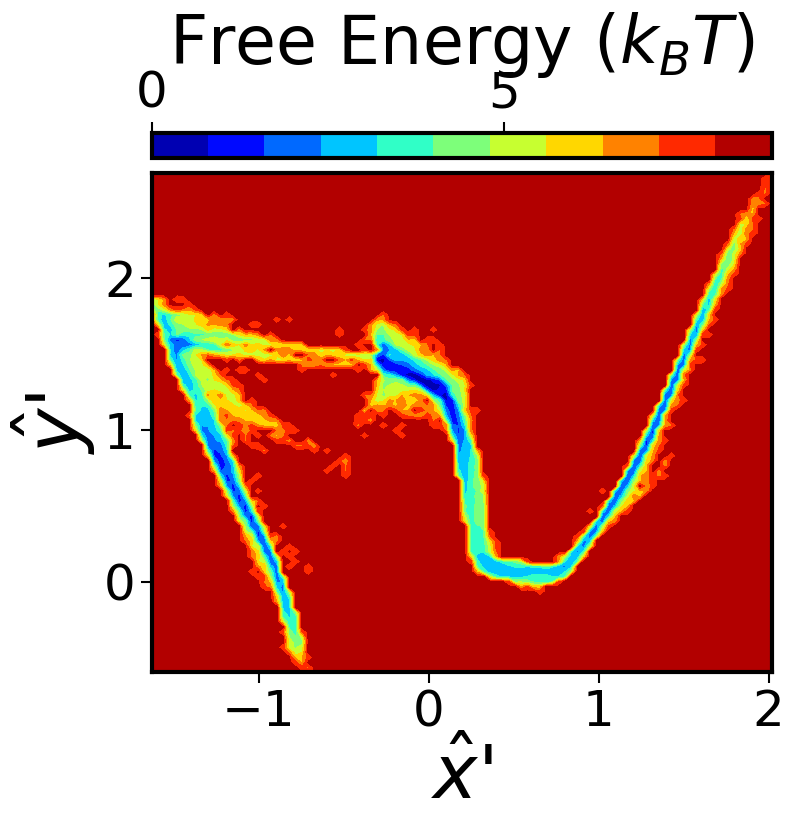

In [30]:
# visualize the reconstruction
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(reconstruction[:,0],reconstruction[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"$\hat{x}$'")
ax.set_ylabel(r"$\hat{y}$'")

In [32]:
# load the finally saved DynamicsAE model
import torch
from models.DynamicsAE import DynamicsAE

z_dim=2
output_shape=(3,)
data_shape=(3,)

neuron_num1=32
neuron_num2=32

projection_num=50
min_dist = 5
bias_factor = 2

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

restore_path=prefix+'cpt1/DynAE_final_cpt.pt'

encoder_type = 'fc_encoder'

decoder_type = 'fc_decoder'

prior_dynamics = 'Langevin'

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

checkpoint=torch.load(restore_path)

AE_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

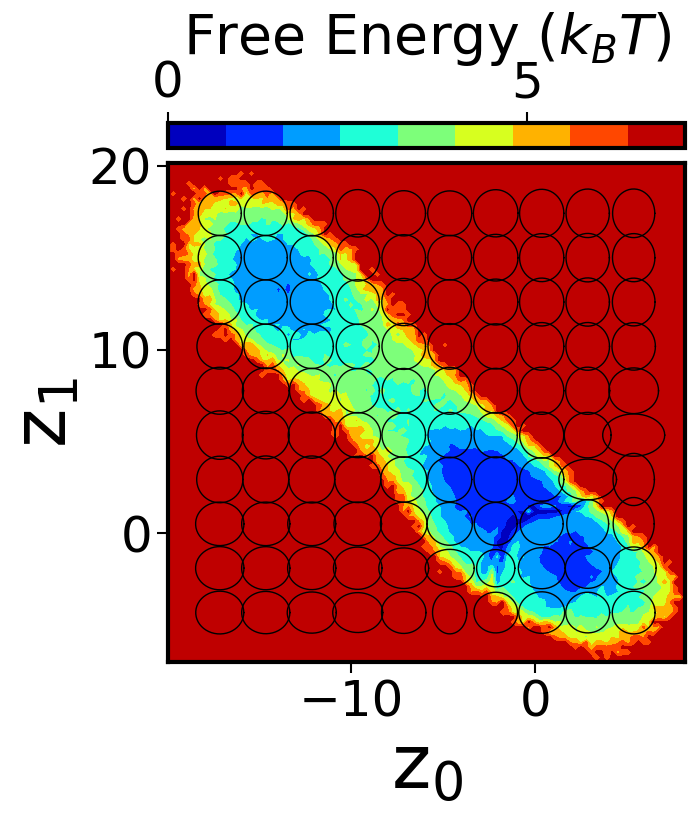

In [34]:
# plot the diffusion learned DynamicsAE
n_pts = 10
batch_size = 256
margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
xx = xx.flatten().cpu().detach().numpy()
yy = yy.flatten().cpu().detach().numpy()
diff = AE_model.model_prior.prior_logdiff(zz).exp()

diff = diff.cpu().detach().numpy()
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.axis('equal')

for i in range(len(xx)):
    plot_ellipse(diff[i], zz[i], ax, plot_scale=1.2)

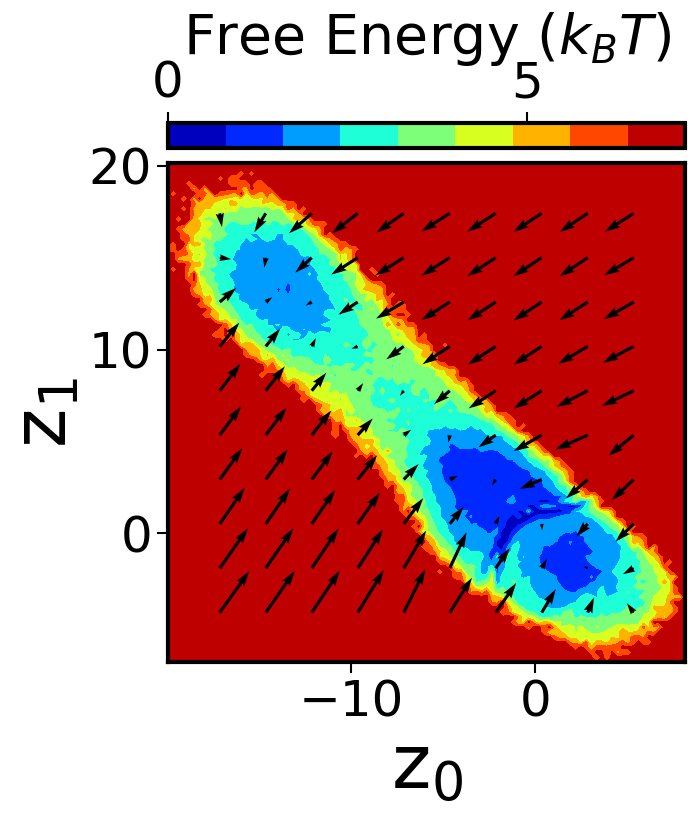

In [35]:
# plot the force field learned DynamicsAE
n_pts = 10
batch_size = 256

margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
zz.requires_grad = True

force = AE_model.model_prior.prior_force(zz)

force = force.cpu().detach().numpy()
force[:,0]=force[:,0]
force[:,1]=force[:,1]
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.set_xlim()
ax.axis('equal')

#ax.quiver(xx,yy,force[:,0],force[:,1]/yy.std)
ax.quiver(xx,yy,force[:,0],force[:,1])

## 3. 2D noise (2-2-2)

In [46]:
# Settings
# ------------------------------------------------------------------------------
# By default, we save all the results in subdirectories of the following path.
base_path = "2dNoise_222_Results"

# Model parameters

# By default, we use all the all the data to train and test our model
t0 = 0
# By default, set dt = 0 like normal auto-encoder
dt = 0

# Dimension of RC or bottleneck
z_dim = 2

# Encoder type (fc_encoder or conv_encoder)
encoder_type = 'fc_encoder'

# Decoder type (fc_decoder or deconv_decoder)
decoder_type = 'fc_decoder'

# Number of nodes in each hidden layer of the encoder
neuron_num1 = 32
# Number of nodes in each hidden layer of the encoder
neuron_num2 = 32

# Model (VAE or DynamicsAE)
model_type = 'DynamicsAE'
model_path = os.path.join(base_path, "DynAE")

# if model_type == 'DynamicsAE':
# Number of projections to approximate sliced wasserstein distance
projection_num = 50

# Minimal distances between cluster centers
min_dist = 5

# Bias factor for resampling
bias_factor = 2

# Prior dynamics (only support Langevin for now)
prior_dynamics = 'Langevin'

# Training parameters
batch_size = 256

# Number of epochs with the change of the state population smaller than the threshold after which this iteration of training finishes
max_epochs = 50

# By default, we save the model every 1 epoch
log_interval = 10

# Period of learning rate decay
lr_scheduler_step_size = 100

# Multiplicative factor of learning rate decay. Default: 1 (No learning rate decay)
lr_scheduler_gamma = 1

# learning rate of Adam optimizer for IB
learning_rate = 1e-3

# Hyper-parameter beta
beta = 10

# Import data

# Load the data
# Path to the input trajectory data
traj = np.random.randn(len(traj), 2)
input_data_list = [traj]

input_data_list = [torch.from_numpy(input_data).float().to(default_device)\
                  for input_data in input_data_list]

# Path to the target data
target_data_list = [torch.from_numpy(traj).float().to(default_device)]

assert len(input_data_list)==len(target_data_list)

# Other controls

# Random seed
seed = 1

# Whether to save trajectory results
SaveTrajResults = True

# Whether to save training progress
SaveTrainingProgress = False

In [37]:
# Train and Test our model
# ------------------------------------------------------------------------------

final_result_path = model_path + '_result.dat'
os.makedirs(os.path.dirname(final_result_path), exist_ok=True)
if os.path.exists(final_result_path):
    print("Final Result", file=open(final_result_path, 'a'))  # append if already exists
else:
    print("Final Result", file=open(final_result_path, 'w'))

np.save(f"{base_path}/inputX.npy", traj)
# set the random seed
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

data_init_list = []
for i in range(len(input_data_list)):
    data_init_list += [utils.data_init(t0, dt, input_data_list[i], target_data_list[i])]

data_shape = data_init_list[0][0]

train_past_data0 = torch.cat([data_init_list[i][1] for i in range(len(input_data_list))], dim=0)
train_past_data1 = torch.cat([data_init_list[i][2] for i in range(len(input_data_list))], dim=0)
train_target_data0 = torch.cat([data_init_list[i][3] for i in range(len(input_data_list))], dim=0)
train_target_data1 = torch.cat([data_init_list[i][4] for i in range(len(input_data_list))], dim=0)

test_past_data0 = torch.cat([data_init_list[i][5] for i in range(len(input_data_list))], dim=0)
test_past_data1 = torch.cat([data_init_list[i][6] for i in range(len(input_data_list))], dim=0)
test_target_data0 = torch.cat([data_init_list[i][7] for i in range(len(input_data_list))], dim=0)
test_target_data1 = torch.cat([data_init_list[i][8] for i in range(len(input_data_list))], dim=0)

output_shape = train_target_data0.shape[1:]

# if model_type == 'DynamicsAE':
prior_learning_rate = learning_rate
output_path = model_path + "_d=%d_dmin=%.1f_b=%f_lr=%f" \
              % (z_dim, min_dist, beta, learning_rate)

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

AE_model.to(device)

AE_model.train()

train_result = AE_model.train_model(beta, input_data_list, train_past_data0,
                                  train_past_data1, train_target_data0,
                                  train_target_data1,
                                  test_past_data0, test_past_data1, test_target_data0,
                                  test_target_data1,
                                  learning_rate, prior_learning_rate,
                                  lr_scheduler_step_size, lr_scheduler_gamma,
                                  batch_size, max_epochs,
                                  output_path, log_interval,
                                  SaveTrainingProgress, seed)

AE_model.eval()
AE_model.output_final_result(train_past_data0, train_past_data1, train_target_data0, train_target_data1,
                          test_past_data0, test_past_data1, test_target_data0, test_target_data1,
                          batch_size, output_path, final_result_path, beta,
                          learning_rate, seed)

for i in range(len(input_data_list)):
    AE_model.save_traj_results(input_data_list[i], batch_size, output_path, SaveTrajResults, i, seed)

Iteration 500:	Time 5.880619 s
Loss (train) 0.722021	Regularization loss (train): 0.142852
Reconstruction loss (train) 0.707736	 Prior loss (train) 1.025033
Loss (test) 1.100241	Regularization loss (test): 0.052905
Reconstruction loss (test) 0.571194	 Prior loss (test) 1.147144
Epoch: 1

Finished after 0.32471513748168945s
5 cluster centers detected

Iteration 1000:	Time 12.299460 s
Loss (train) 0.932777	Regularization loss (train): 0.092086
Reconstruction loss (train) 0.011920	 Prior loss (train) 1.020135
Loss (test) 1.356620	Regularization loss (test): 0.134612
Reconstruction loss (test) 0.010504	 Prior loss (test) 0.902772
Epoch: 2

Finished after 0.486130952835083s
4 cluster centers detected

Iteration 1500:	Time 18.598764 s
Loss (train) 0.532487	Regularization loss (train): 0.052494
Reconstruction loss (train) 0.007551	 Prior loss (train) 1.096857
Loss (test) 0.658913	Regularization loss (test): 0.065034
Reconstruction loss (test) 0.008572	 Prior loss (test) 1.023163
Epoch: 3

Fin

In [47]:
prefix=f'{base_path}/DynAE_d=2_dmin=5.0_b=10.000000_lr=0.001000'
repeat='1'

In [48]:
# load the results
# the latent representation recovered by Dynamics-AE
latent_rep=np.load(prefix+"_traj0_representation"+repeat+".npy")
# the reconstruction leanred by Dynamics-AE
reconstruction=np.load(prefix+"_traj0_data_prediction"+repeat+".npy")
# the cluster centers from regular space clustering in the latent space
cluster_centers=np.load(prefix+'_z_cluster_centers'+repeat+".npy")

(np.float64(-4.258245468139648),
 np.float64(7.07346773147583),
 np.float64(-4.944129943847656),
 np.float64(5.621334075927734))

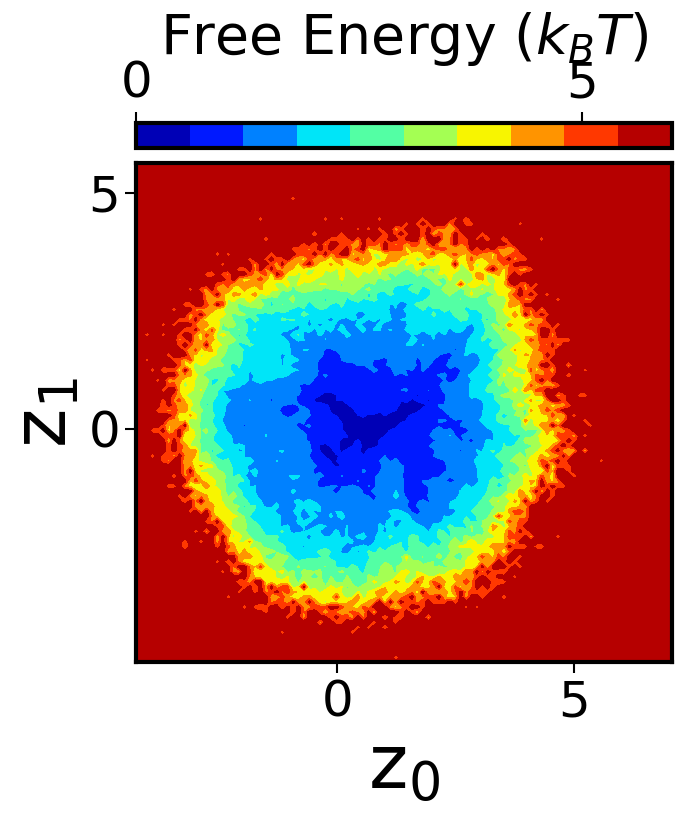

In [49]:
# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.axis('equal')

Text(0, 0.5, "$\\hat{y}$'")

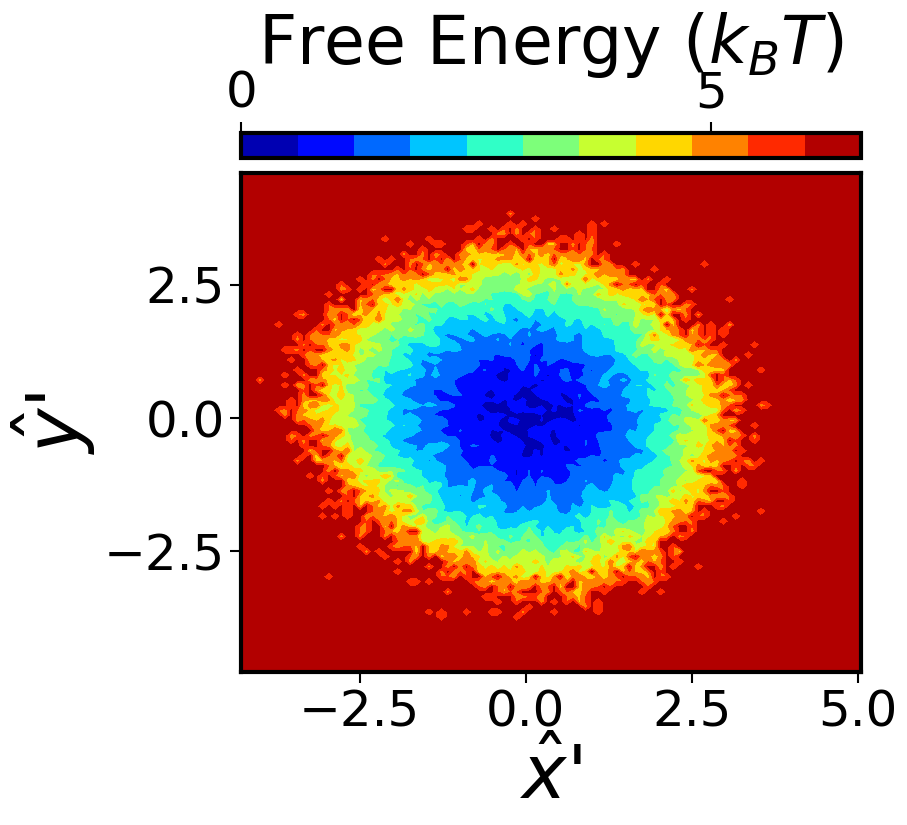

In [50]:
# visualize the reconstruction
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(reconstruction[:,0],reconstruction[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"$\hat{x}$'")
ax.set_ylabel(r"$\hat{y}$'")

In [51]:
# load the finally saved DynamicsAE model
import torch
from models.DynamicsAE import DynamicsAE

z_dim=2
output_shape=(2,)
data_shape=(2,)

neuron_num1=32
neuron_num2=32

projection_num=50
min_dist = 5
bias_factor = 2

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

restore_path=prefix+'cpt1/DynAE_final_cpt.pt'

encoder_type = 'fc_encoder'

decoder_type = 'fc_decoder'

prior_dynamics = 'Langevin'

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

checkpoint=torch.load(restore_path)

AE_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

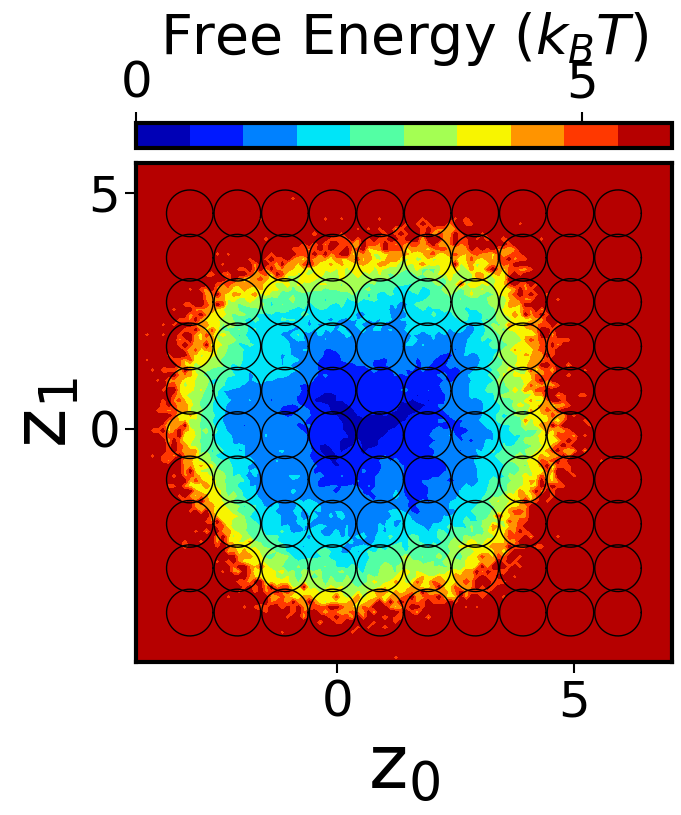

In [53]:
# plot the diffusion learned DynamicsAE
n_pts = 10
batch_size = 256
margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
xx = xx.flatten().cpu().detach().numpy()
yy = yy.flatten().cpu().detach().numpy()
diff = AE_model.model_prior.prior_logdiff(zz).exp()

diff = diff.cpu().detach().numpy()
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.axis('equal')

for i in range(len(xx)):
    plot_ellipse(diff[i], zz[i], ax, plot_scale=0.5)

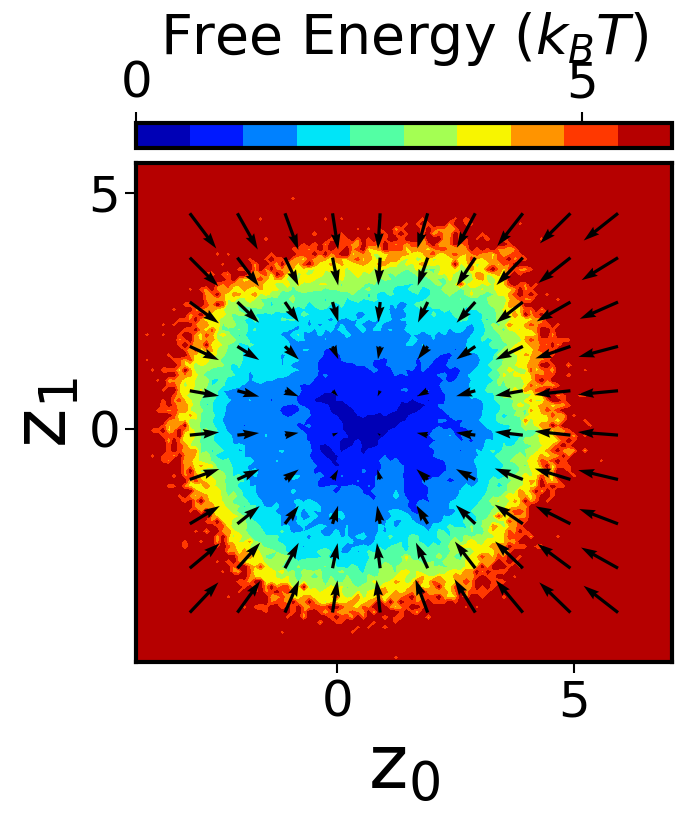

In [54]:
# plot the force field learned DynamicsAE
n_pts = 10
batch_size = 256

margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
zz.requires_grad = True

force = AE_model.model_prior.prior_force(zz)

force = force.cpu().detach().numpy()
force[:,0]=force[:,0]
force[:,1]=force[:,1]
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.set_xlim()
ax.axis('equal')

#ax.quiver(xx,yy,force[:,0],force[:,1]/yy.std)
ax.quiver(xx,yy,force[:,0],force[:,1])

## 4. 3d Noise (3-2-3)

In [55]:
# Settings
# ------------------------------------------------------------------------------
# By default, we save all the results in subdirectories of the following path.
base_path = "3dNoise_323_Results"

# Model parameters

# By default, we use all the all the data to train and test our model
t0 = 0
# By default, set dt = 0 like normal auto-encoder
dt = 0

# Dimension of RC or bottleneck
z_dim = 2

# Encoder type (fc_encoder or conv_encoder)
encoder_type = 'fc_encoder'

# Decoder type (fc_decoder or deconv_decoder)
decoder_type = 'fc_decoder'

# Number of nodes in each hidden layer of the encoder
neuron_num1 = 32
# Number of nodes in each hidden layer of the encoder
neuron_num2 = 32

# Model (VAE or DynamicsAE)
model_type = 'DynamicsAE'
model_path = os.path.join(base_path, "DynAE")

# if model_type == 'DynamicsAE':
# Number of projections to approximate sliced wasserstein distance
projection_num = 50

# Minimal distances between cluster centers
min_dist = 5

# Bias factor for resampling
bias_factor = 2

# Prior dynamics (only support Langevin for now)
prior_dynamics = 'Langevin'

# Training parameters
batch_size = 256

# Number of epochs with the change of the state population smaller than the threshold after which this iteration of training finishes
max_epochs = 50

# By default, we save the model every 1 epoch
log_interval = 10

# Period of learning rate decay
lr_scheduler_step_size = 100

# Multiplicative factor of learning rate decay. Default: 1 (No learning rate decay)
lr_scheduler_gamma = 1

# learning rate of Adam optimizer for IB
learning_rate = 1e-3

# Hyper-parameter beta
beta = 10

# Import data

# Load the data
# Path to the input trajectory data
traj = np.random.randn(len(traj), 3)
input_data_list = [traj]

input_data_list = [torch.from_numpy(input_data).float().to(default_device)\
                  for input_data in input_data_list]

# Path to the target data
target_data_list = [torch.from_numpy(traj).float().to(default_device)]

assert len(input_data_list)==len(target_data_list)

# Other controls

# Random seed
seed = 1

# Whether to save trajectory results
SaveTrajResults = True

# Whether to save training progress
SaveTrainingProgress = False

In [56]:
# Train and Test our model
# ------------------------------------------------------------------------------

final_result_path = model_path + '_result.dat'
os.makedirs(os.path.dirname(final_result_path), exist_ok=True)
if os.path.exists(final_result_path):
    print("Final Result", file=open(final_result_path, 'a'))  # append if already exists
else:
    print("Final Result", file=open(final_result_path, 'w'))

np.save(f"{base_path}/inputX.npy", traj)

# set the random seed
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

data_init_list = []
for i in range(len(input_data_list)):
    data_init_list += [utils.data_init(t0, dt, input_data_list[i], target_data_list[i])]

data_shape = data_init_list[0][0]

train_past_data0 = torch.cat([data_init_list[i][1] for i in range(len(input_data_list))], dim=0)
train_past_data1 = torch.cat([data_init_list[i][2] for i in range(len(input_data_list))], dim=0)
train_target_data0 = torch.cat([data_init_list[i][3] for i in range(len(input_data_list))], dim=0)
train_target_data1 = torch.cat([data_init_list[i][4] for i in range(len(input_data_list))], dim=0)

test_past_data0 = torch.cat([data_init_list[i][5] for i in range(len(input_data_list))], dim=0)
test_past_data1 = torch.cat([data_init_list[i][6] for i in range(len(input_data_list))], dim=0)
test_target_data0 = torch.cat([data_init_list[i][7] for i in range(len(input_data_list))], dim=0)
test_target_data1 = torch.cat([data_init_list[i][8] for i in range(len(input_data_list))], dim=0)

output_shape = train_target_data0.shape[1:]

# if model_type == 'DynamicsAE':
prior_learning_rate = learning_rate
output_path = model_path + "_d=%d_dmin=%.1f_b=%f_lr=%f" \
              % (z_dim, min_dist, beta, learning_rate)

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

AE_model.to(device)

AE_model.train()

train_result = AE_model.train_model(beta, input_data_list, train_past_data0,
                                  train_past_data1, train_target_data0,
                                  train_target_data1,
                                  test_past_data0, test_past_data1, test_target_data0,
                                  test_target_data1,
                                  learning_rate, prior_learning_rate,
                                  lr_scheduler_step_size, lr_scheduler_gamma,
                                  batch_size, max_epochs,
                                  output_path, log_interval,
                                  SaveTrainingProgress, seed)

AE_model.eval()
AE_model.output_final_result(train_past_data0, train_past_data1, train_target_data0, train_target_data1,
                          test_past_data0, test_past_data1, test_target_data0, test_target_data1,
                          batch_size, output_path, final_result_path, beta,
                          learning_rate, seed)

for i in range(len(input_data_list)):
    AE_model.save_traj_results(input_data_list[i], batch_size, output_path, SaveTrajResults, i, seed)

Iteration 500:	Time 5.975526 s
Loss (train) 2.948625	Regularization loss (train): 0.292937
Reconstruction loss (train) 2.919332	 Prior loss (train) 0.899891
Loss (test) 5.267913	Regularization loss (test): 0.267916
Reconstruction loss (test) 2.588753	 Prior loss (test) 0.979774
Epoch: 1

Finished after 0.8305459022521973s
4 cluster centers detected

Iteration 1000:	Time 14.540014 s
Loss (train) 2.264589	Regularization loss (train): 0.037735
Reconstruction loss (train) 1.887240	 Prior loss (train) 0.948626
Loss (test) 2.145916	Regularization loss (test): 0.043267
Reconstruction loss (test) 1.713249	 Prior loss (test) 1.027198
Epoch: 2

Finished after 0.2991194725036621s
4 cluster centers detected

Iteration 1500:	Time 20.372819 s
Loss (train) 2.480400	Regularization loss (train): 0.062074
Reconstruction loss (train) 1.859663	 Prior loss (train) 0.967645
Loss (test) 2.587091	Regularization loss (test): 0.112347
Reconstruction loss (test) 1.463617	 Prior loss (test) 0.922425
Epoch: 3

Fin

In [57]:
prefix=f'{base_path}/DynAE_d=2_dmin=5.0_b=10.000000_lr=0.001000'
repeat='1'

In [58]:
# load the results
# the latent representation recovered by Dynamics-AE
latent_rep=np.load(prefix+"_traj0_representation"+repeat+".npy")
# the reconstruction leanred by Dynamics-AE
reconstruction=np.load(prefix+"_traj0_data_prediction"+repeat+".npy")
# the cluster centers from regular space clustering in the latent space
cluster_centers=np.load(prefix+'_z_cluster_centers'+repeat+".npy")

Text(0, 0.5, 'y')

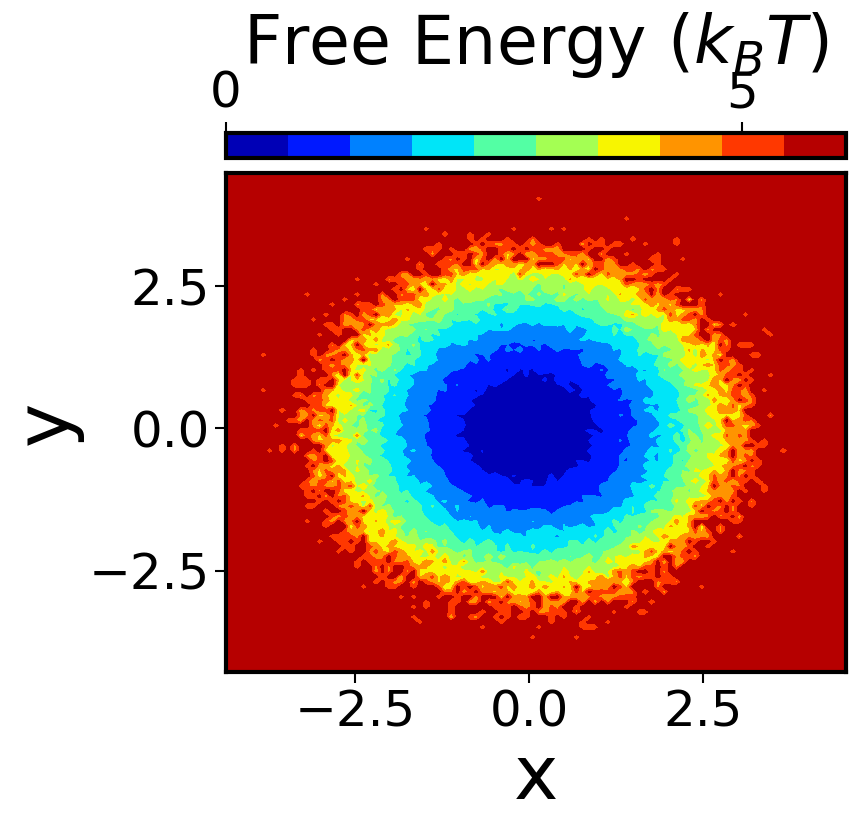

In [64]:
# visualize the input
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

inputs = np.load(f'{base_path}/inputX.npy')

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(inputs[:,0],inputs[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")

Text(0, 0.5, '$\\hat{y}$')

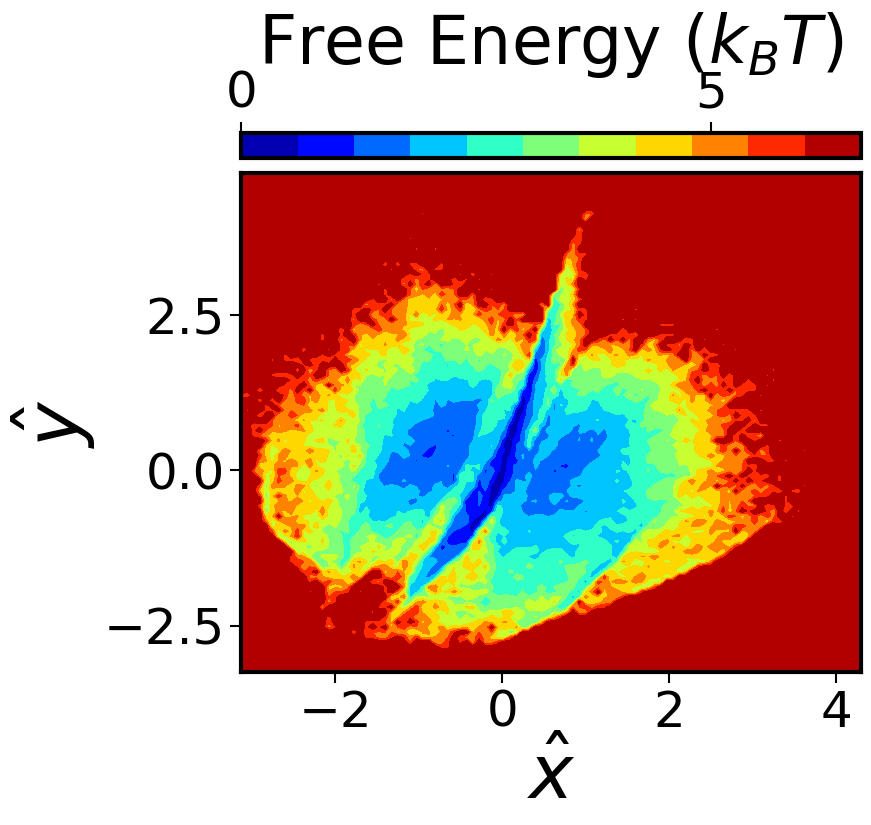

In [65]:
# visualize the reconstruction
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(reconstruction[:,0],reconstruction[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"$\hat{x}$")
ax.set_ylabel(r"$\hat{y}$")

In [60]:
# load the finally saved DynamicsAE model
import torch
from models.DynamicsAE import DynamicsAE

z_dim=2
output_shape=(3,)
data_shape=(3,)

neuron_num1=32
neuron_num2=32

projection_num=50
min_dist = 5
bias_factor = 2

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

restore_path=prefix+'cpt1/DynAE_final_cpt.pt'

encoder_type = 'fc_encoder'

decoder_type = 'fc_decoder'

prior_dynamics = 'Langevin'

AE_model = DynamicsAE(encoder_type, decoder_type, prior_dynamics, z_dim, output_shape,
                      data_shape, projection_num, min_dist, bias_factor, device, neuron_num1, neuron_num2)

checkpoint=torch.load(restore_path)

AE_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

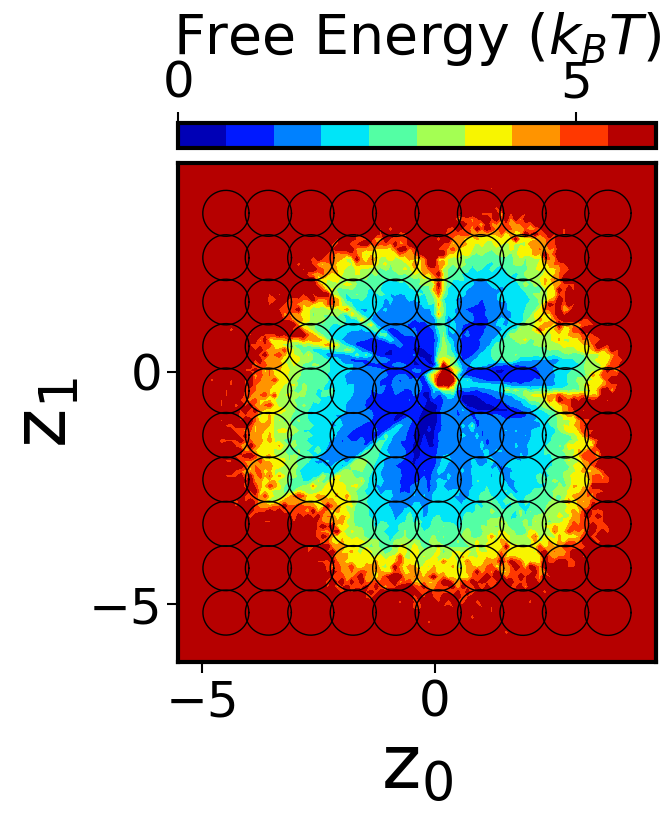

In [63]:
# plot the diffusion learned DynamicsAE
n_pts = 10
batch_size = 256
margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
xx = xx.flatten().cpu().detach().numpy()
yy = yy.flatten().cpu().detach().numpy()
diff = AE_model.model_prior.prior_logdiff(zz).exp()

diff = diff.cpu().detach().numpy()
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.axis('equal')

for i in range(len(xx)):
    plot_ellipse(diff[i], zz[i], ax, plot_scale=0.5)

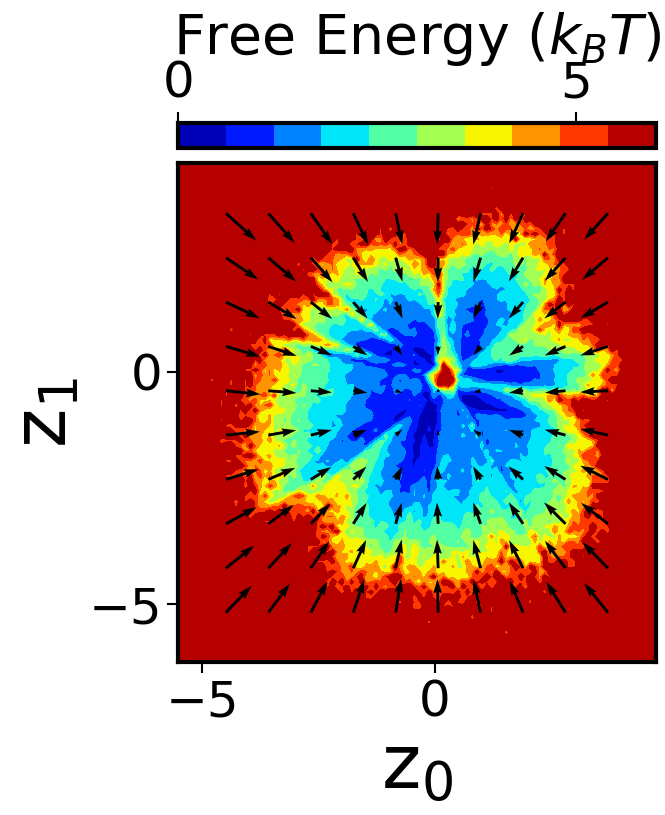

In [62]:
# plot the force field learned DynamicsAE
n_pts = 10
batch_size = 256

margin = (latent_rep.max(axis=0)-latent_rep.min(axis=0))/n_pts
x = torch.linspace(latent_rep.min(axis=0)[0]+margin[0], latent_rep.max(axis=0)[0]-margin[0], n_pts)
y = torch.linspace(latent_rep.min(axis=0)[1]+margin[1], latent_rep.max(axis=0)[1]-margin[1], n_pts)
xx, yy = torch.meshgrid((x, y))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
zz.requires_grad = True

force = AE_model.model_prior.prior_force(zz)

force = force.cpu().detach().numpy()
force[:,0]=force[:,0]
force[:,1]=force[:,1]
zz = zz.cpu().detach().numpy()
# plot
fig, ax = plt.subplots(figsize=(9,7))

# visualize the learned latent space
from mpl_toolkits.axes_grid1 import make_axes_locatable

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(latent_rep[:,0],latent_rep[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

h0=plt.contourf(RC_G.transpose(),levels=10,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=40)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"z$_0$")
ax.set_ylabel(r"z$_1$")
ax.set_xlim()
ax.axis('equal')

#ax.quiver(xx,yy,force[:,0],force[:,1]/yy.std)
ax.quiver(xx,yy,force[:,0],force[:,1])